# Roberta Classification

### Links

https://towardsdatascience.com/fine-tuning-bert-and-roberta-for-high-accuracy-text-classification-in-pytorch-c9e63cf64646 
https://huggingface.co/docs/transformers/en/perf_torch_compile (can be used on GPU , dependency : visual basic C++ tools)

In [487]:
#importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import spacy ## Preprocessing
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import re ## Preprocessing
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

import torch
import torchtext
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator
#from torchtext import data
#from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
from transformers import RobertaTokenizer, RobertaModel, AdamW, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader

import warnings
warnings.filterwarnings('ignore')

device = torch.device('cpu')
tokenizer = RobertaTokenizer.from_pretrained(r"\\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base",return_dict=False)
output_path=r"C:\Users\KPA2877\Documents"
data_path=r"C:\Users\KPA2877\Documents"

In [488]:
#!pip uninstall torchtext

In [489]:
#!pip show torchtext==0.6

In [490]:
df=pd.read_excel(r"DATA.xlsx")

In [491]:
df.head(5)

Sentence  \
0  qaa details documented verbal consent obtained...   
1  apologized to mrs robinson and i would submit ...   
2  griev documented is sharing that the griev 042...   
3  qaa details documented qaa template completed ...   
4  appeal details cancellation fees times at leas...   

                                                Tag  
0  Appearance of Site and Provider Customer Service  
1            Appearance of Site and Quality of Care  
2                Access and Humana Customer Service  
3  Appearance of Site and Provider Customer Service  
4              Access and Provider Customer Service

In [492]:
from sklearn.preprocessing import MultiLabelBinarizer

# Split the labels by "and"
df['labels'] = df['Tag'].apply(lambda x: x.split(' and '))

#df.to_csv('df.csv')

In [493]:
#df = pd.read_csv('df.csv')
#df.head()

In [494]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the labels
df['binary_labels'] = list(mlb.fit_transform(df['labels']))

# Display the transformed labels
print(df[['Tag', 'binary_labels']])

                                                   Tag  \
0     Appearance of Site and Provider Customer Service   
1               Appearance of Site and Quality of Care   
2                   Access and Humana Customer Service   
3     Appearance of Site and Provider Customer Service   
4                 Access and Provider Customer Service   
...                                                ...   
1060                                         Marketing   
1061                                   Quality of Care   
1062                                         Marketing   
1063                                            Access   
1064                                Appearance of Site   

                       binary_labels  
0     [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  
1     [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]  
2     [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]  
3     [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  
4     [1, 0, 0, 0, 0, 0, 0, 0, 1, 0]  
...                              ...  
1060  [0, 0, 0, 0, 0, 0, 1, 0,

In [495]:
print(mlb.classes_)

['Access' 'Appearance of Site' 'Benefit Package' 'CMS issue'
 'Enrollment / Disenrollment' 'Humana Customer Service' 'Marketing'
 'Other' 'Provider Customer Service' 'Quality of Care']


In [496]:
df.head()

Sentence  \
0  qaa details documented verbal consent obtained...   
1  apologized to mrs robinson and i would submit ...   
2  griev documented is sharing that the griev 042...   
3  qaa details documented qaa template completed ...   
4  appeal details cancellation fees times at leas...   

                                                Tag  \
0  Appearance of Site and Provider Customer Service   
1            Appearance of Site and Quality of Care   
2                Access and Humana Customer Service   
3  Appearance of Site and Provider Customer Service   
4              Access and Provider Customer Service   

                                            labels  \
0  [Appearance of Site, Provider Customer Service]   
1            [Appearance of Site, Quality of Care]   
2                [Access, Humana Customer Service]   
3  [Appearance of Site, Provider Customer Service]   
4              [Access, Provider Customer Service]   

                    binary_labels  
0  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  
1  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]  
2  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]  
3  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  
4  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [497]:
#df=pd.read_excel(r"Training_Data_Nandini.xlsx")
#df['Tag'] = df['Tag'].map({#'Organization Determination / Reconsideration': 0,
#'Marketing':0,
#'Humana Customer Service':1,
#'Other':2,
#'CMS issue':3,
#'Enrollment / Disenrollment':4,
#'Benefit Package':5,
#'Appearance of Site':6,
#'Quality of Care':7,
#'Access':8,
#'Provider Customer Service':9})
#
## Filling NaN values with a default integer value, e.g., -1
##df['Tag'] = df['Tag'].fillna(-1)
## Remove rows with NaN values in 'Tag' column
#df = df.dropna(subset=['Tag'])
## Convert 'Tag' column to integers
#df['Tag'] = df['Tag'].astype(int)

In [498]:
#df['Tag'].value_counts()

In [499]:
## Preprocessing steps(Lower the cases)
df['Sentence']=df['Sentence'].apply(str.lower).str.strip()
nlp = spacy.load("en_core_web_lg")

In [500]:
#!python -m spacy download en_core_web_lg

In [501]:
def process_sentence(sentence):
    
    doc = nlp(sentence)  # Process the sentence with SpaCy
    cleaned_tokens = []   # Initialize an empty list to store modified tokens
    for token in doc:
        # Check if the token is not a name, organization, or location
        if token.ent_type_ not in ['PERSON', 'ORG', 'GPE']:
            # If not, add the token text to the cleaned_tokens list
            cleaned_tokens.append(token.text)
    cleaned_sentence = ' '.join(cleaned_tokens)  # Join the cleaned tokens back into a string
    return cleaned_sentence
   
   
def preprocess_text(text):
# Convert text to lowercase and strip whitespace
    text = text.lower().strip()
    # Remove hyperlinks
    text = re.sub(r'<a\s+(?:[^>]*?\s+)?href=(["\'])(.*?)\1[^>]*>(.*?)</a>', r'\3', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z .,!?]', '', text)   
    text=text.strip()
    # Apply SpaCy processing to the text
    cleaned_text = process_sentence(text)
   
    return cleaned_text
        

In [502]:
df['Sentence'] = df['Sentence'].apply(preprocess_text)

In [503]:
#df.to_csv(r"C:\Users\KPA2877\Documents\Content_Train_Data_27_05_2024_multilabel.csv")

In [504]:
df = pd.DataFrame(df[['Sentence','binary_labels']])

In [505]:
df.shape

(1065, 2)

In [506]:
df.head()

Sentence  \
0  qaa details documented verbal consent obtained...   
1  apologized to mrs robinson and i would submit ...   
2  griev documented is sharing that the griev was...   
3  qaa details documented qaa template completed ...   
4  appeal details cancellation fees times at leas...   

                    binary_labels  
0  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  
1  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]  
2  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]  
3  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  
4  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0]

# Training

In [507]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.1):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained(r"\\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base")
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 10)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask,return_dict=False)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)# check
        x = self.d2(x)
        x = self.l2(x)

        # Apply sigmoid activation for multi-label classification
        x = torch.sigmoid(x)
        
        return x  

In [508]:
# Set tokenizer hyperparameters.
MAX_SEQ_LEN = 128
BATCH_SIZE = 16 ## Training data is more hence the batch size is 32
PAD_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.pad_token)
UNK_INDEX = tokenizer.convert_tokens_to_ids(tokenizer.unk_token)
# Define columns to read.
import torchtext
from torchtext.data import Field, TabularDataset, BucketIterator, Iterator

# Define the fields as a list of tuples
label_field = Field(sequential=True, use_vocab=False, batch_first=True, dtype=torch.float)
text_field = Field(use_vocab=False, 
                   tokenize=tokenizer.encode, 
                   include_lengths=False, 
                   batch_first=True,
                   fix_length=MAX_SEQ_LEN, 
                   pad_token=PAD_INDEX, 
                   unk_token=UNK_INDEX)

fields = [('Sentence', text_field), ('binary_labels', label_field)]

# Function to convert DataFrame to Examples
def df_to_examples(dataframe, fields):
    examples = []
    for i, row in dataframe.iterrows():
        example = torchtext.data.Example.fromlist([row['Sentence'], row['binary_labels']], fields)
        examples.append(example)
    return examples

# Function to convert DataFrame to Dataset
def df_to_dataset(dataframe, fields):
    examples = df_to_examples(dataframe, fields)
    dataset = torchtext.data.Dataset(examples, fields)
    return dataset

# Convert DataFrames to TabularDataset
train_data = df_to_dataset(train_df, fields)
valid_data = df_to_dataset(valid_df, fields)
test_data = df_to_dataset(test_df, fields)

# Create Iterators
train_iter, valid_iter = BucketIterator.splits((train_data, valid_data),
                                               batch_size=BATCH_SIZE,
                                               device=device,
                                               shuffle=True,
                                               sort_key=lambda x: len(x.Sentence), 
                                               sort=True, 
                                               sort_within_batch=False)

test_iter = Iterator(test_data, batch_size=BATCH_SIZE, device=device, train=False, shuffle=False, sort=False)


In [509]:
df.head()

Sentence  \
0  qaa details documented verbal consent obtained...   
1  apologized to mrs robinson and i would submit ...   
2  griev documented is sharing that the griev was...   
3  qaa details documented qaa template completed ...   
4  appeal details cancellation fees times at leas...   

                    binary_labels  
0  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  
1  [0, 1, 0, 0, 0, 0, 0, 0, 0, 1]  
2  [1, 0, 0, 0, 0, 1, 0, 0, 0, 0]  
3  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0]  
4  [1, 0, 0, 0, 0, 0, 0, 0, 1, 0]

In [510]:
# Functions for saving and loading model parameters and metrics.
def save_checkpoint(path, model, valid_loss):
    torch.save({'model_state_dict': model.state_dict(),
                  'valid_loss': valid_loss}, path)
        
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['valid_loss']

def save_metrics(path, train_loss_list, valid_loss_list, global_steps_list):   
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    torch.save(state_dict, path)

def load_metrics(path):    
    state_dict = torch.load(path, map_location=device)
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [511]:
def pretrain(model, 
             optimizer, 
             train_iter, 
             valid_iter, 
             scheduler=None,
             valid_period=len(train_iter),
             num_epochs=5):
    
    # Pretrain linear layers, do not train RoBERTa
    for param in model.roberta.parameters():
        param.requires_grad = False
    
    model.train()
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0   
    global_step = 0  
    
    # Train loop
    for epoch in range(num_epochs):
        for batch in train_iter:
            source = batch.Sentence
            target = batch.binary_labels
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            y_pred = model(input_ids=source, attention_mask=mask)
            
            loss = torch.nn.BCEWithLogitsLoss()(y_pred, target)
   
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()
            if scheduler:
                scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                
                with torch.no_grad():                    
                    for batch in valid_iter:
                        source = batch.Sentence
                        target = batch.binary_labels
                        mask = (source != PAD_INDEX).type(torch.uint8)
                        
                        y_pred = model(input_ids=source, attention_mask=mask)
                        
                        loss = torch.nn.BCEWithLogitsLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                
                model.train()

                # Print summary
                print('Epoch [{}/{}], global step [{}/{}], PT Loss: {:.4f}, Val Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_iter),
                              train_loss, valid_loss))
                
                train_loss = 0.0                
                valid_loss = 0.0
    
    # Set RoBERTa parameters back to trainable
    for param in model.roberta.parameters():
        param.requires_grad = True
        
    print('Pre-training done!')

In [512]:
import time

def train(model,
          optimizer,
          train_iter,
          valid_iter,
          scheduler=None,
          num_epochs=5,
          valid_period=len(train_iter),
          output_path=output_path):
    
    # Initialize losses and loss histories
    train_loss = 0.0
    valid_loss = 0.0
    train_loss_list = []
    valid_loss_list = []
    best_valid_loss = float('Inf')
    
    global_step = 0
    global_steps_list = []
    
    model.train()
    
    # Track overall training time
    overall_start_time = time.time()
    
    # Train loop
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        
        for batch in train_iter:
            source = batch.Sentence
            target = batch.binary_labels
            mask = (source != PAD_INDEX).type(torch.uint8)

            y_pred = model(input_ids=source, attention_mask=mask)
            
            loss = torch.nn.BCEWithLogitsLoss()(y_pred, target)
            
            loss.backward()
            
            # Optimizer and scheduler step
            optimizer.step()
            if scheduler:
                scheduler.step()
                
            optimizer.zero_grad()
            
            # Update train loss and global step
            train_loss += loss.item()
            global_step += 1

            # Validation loop. Save progress and evaluate model performance.
            if global_step % valid_period == 0:
                model.eval()
                valid_preds = []
                valid_labels = []
                
                with torch.no_grad():                    
                    for batch in valid_iter:
                        source = batch.Sentence
                        target = batch.binary_labels
                        mask = (source != PAD_INDEX).type(torch.uint8)

                        y_pred = model(input_ids=source, attention_mask=mask)
                        
                        loss = torch.nn.BCEWithLogitsLoss()(y_pred, target)
                        
                        valid_loss += loss.item()

                        valid_preds.extend(torch.sigmoid(y_pred).cpu().numpy())
                        valid_labels.extend(target.cpu().numpy())

                # Store train and validation loss history
                train_loss = train_loss / valid_period
                valid_loss = valid_loss / len(valid_iter)
                train_loss_list.append(train_loss)
                valid_loss_list.append(valid_loss)
                global_steps_list.append(global_step)

                # Calculate metrics
                valid_preds = (np.array(valid_preds) >= 0.5).astype(int)
                accuracy = accuracy_score(valid_labels, valid_preds)
                precision, recall, f1, _ = precision_recall_fscore_support(valid_labels, valid_preds, average='weighted')

                # Print summary
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{global_step}/{num_epochs*len(train_iter)}], '
                      f'Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}, '
                      f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
                      f'Recall: {recall:.4f}, F1: {f1:.4f}')
                
                # Checkpoint
                if best_valid_loss > valid_loss:
                    best_valid_loss = valid_loss
                    save_checkpoint(output_path + '/model.pkl', model, best_valid_loss)
                    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)
                        
                train_loss = 0.0                
                valid_loss = 0.0
                model.train()
        
        epoch_end_time = time.time()
        epoch_duration = epoch_end_time - epoch_start_time
        print(f'Epoch [{epoch+1}/{num_epochs}] completed in {epoch_duration:.2f} seconds')
    
    overall_end_time = time.time()
    overall_duration = overall_end_time - overall_start_time
    print(f'Training completed in {overall_duration:.2f} seconds')
    
    save_metrics(output_path + '/metric.pkl', train_loss_list, valid_loss_list, global_steps_list)

    print('Training done!')

In [513]:
# Main training loop
NUM_EPOCHS = 10
steps_per_epoch = len(train_iter)

model = ROBERTAClassifier(0.5)
model = model.to(device)


optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*1, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

print("======================= Start pretraining ==============================")

pretrain(model=model,
         train_iter=train_iter,
         valid_iter=valid_iter,
         optimizer=optimizer,
         scheduler=scheduler,
         num_epochs=NUM_EPOCHS)

NUM_EPOCHS = 150
print("======================= Start training =================================")
optimizer = AdamW(model.parameters(), lr=2e-6)
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps=steps_per_epoch*2, 
                                            num_training_steps=steps_per_epoch*NUM_EPOCHS)

train(model=model, 
      train_iter=train_iter, 
      valid_iter=valid_iter, 
      optimizer=optimizer, 
      scheduler=scheduler, 
      num_epochs=NUM_EPOCHS)

Some weights of RobertaModel were not initialized from the model checkpoint at \\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


======================= Start pretraining ==============================
Epoch [1/10], global step [8/80], PT Loss: 0.8935, Val Loss: 0.8873
Epoch [2/10], global step [16/80], PT Loss: 0.8718, Val Loss: 0.8476
Epoch [3/10], global step [24/80], PT Loss: 0.8480, Val Loss: 0.8240
Epoch [4/10], global step [32/80], PT Loss: 0.8292, Val Loss: 0.8112
Epoch [5/10], global step [40/80], PT Loss: 0.8204, Val Loss: 0.8038
Epoch [6/10], global step [48/80], PT Loss: 0.8172, Val Loss: 0.7993
Epoch [7/10], global step [56/80], PT Loss: 0.8110, Val Loss: 0.7966
Epoch [8/10], global step [64/80], PT Loss: 0.8098, Val Loss: 0.7950
Epoch [9/10], global step [72/80], PT Loss: 0.8071, Val Loss: 0.7941
Epoch [10/10], global step [80/80], PT Loss: 0.8072, Val Loss: 0.7938
Pre-training done!
======================= Start training =================================
Epoch [1/150], Step [8/1200], Train Loss: 0.8070, Valid Loss: 0.7937, Accuracy: 0.0000, Precision: 0.2413, Recall: 1.0000, F1: 0.3800
Epoch [1/15

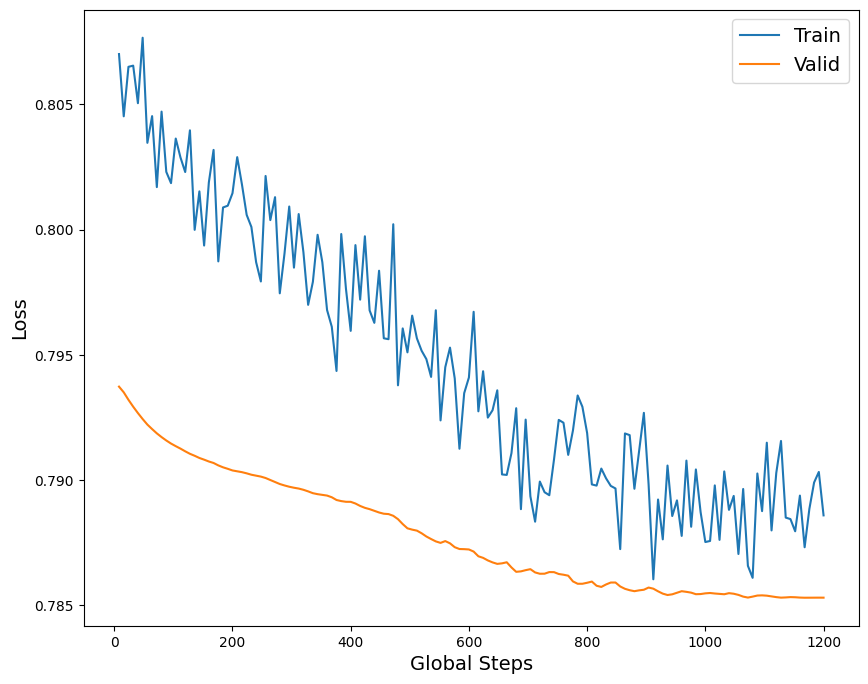

In [514]:
plt.figure(figsize=(10, 8))
train_loss_list, valid_loss_list, global_steps_list = load_metrics(output_path + '/metric.pkl')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.legend(fontsize=14)
plt.show() 

# Evaluation

In [515]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt

# Evaluation Function for Multi-Label Classification
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            source = batch.Sentence
            target = batch.binary_labels
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            output = model(source, attention_mask=mask)
            
            y_pred.extend(output.cpu().numpy())
            y_true.extend(target.cpu().numpy())
    
    # Convert predictions to binary format
    y_pred = (np.array(y_pred) >= 0.5).astype(int)
    y_true = np.array(y_true)
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=[str(i) for i in range(10)], digits=4))
    
    # Compute confusion matrix for each label
    cm = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1), labels=[i for i in range(10)])
    ax = plt.subplot()

    sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels([str(i) for i in range(10)])
    ax.yaxis.set_ticklabels([str(i) for i in range(10)])
    plt.show()


Some weights of RobertaModel were not initialized from the model checkpoint at \\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        13
           1     0.0000    0.0000    0.0000         8
           2     0.0000    0.0000    0.0000         3
           3     0.0000    0.0000    0.0000         3
           4     0.0000    0.0000    0.0000         5
           5     0.0000    0.0000    0.0000         7
           6     0.0000    0.0000    0.0000         4
           7     0.0000    0.0000    0.0000         6
           8     0.0000    0.0000    0.0000         9
           9     0.5000    0.2000    0.2857        10

   micro avg     0.5000    0.0294    0.0556        68
   macro avg     0.0500    0.0200    0.0286        68
weighted avg     0.0735    0.0294    0.0420        68
 samples avg     0.0588    0.0294    0.0392        68



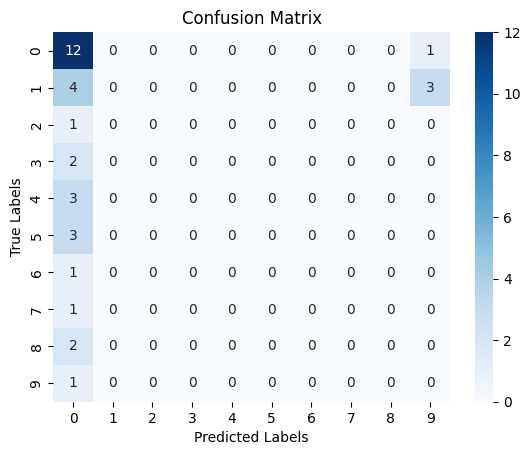

In [516]:
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model.pkl', model)
evaluate(model, valid_iter)

Some weights of RobertaModel were not initialized from the model checkpoint at \\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        40
           1     0.0000    0.0000    0.0000        29
           2     0.0000    0.0000    0.0000        17
           3     0.0000    0.0000    0.0000         8
           4     0.0000    0.0000    0.0000        15
           5     0.0000    0.0000    0.0000        31
           6     0.0000    0.0000    0.0000         7
           7     0.0000    0.0000    0.0000        17
           8     0.0000    0.0000    0.0000        33
           9     0.9167    0.6667    0.7719        33

   micro avg     0.9167    0.0957    0.1732       230
   macro avg     0.0917    0.0667    0.0772       230
weighted avg     0.1315    0.0957    0.1108       230
 samples avg     0.1849    0.0966    0.1261       230



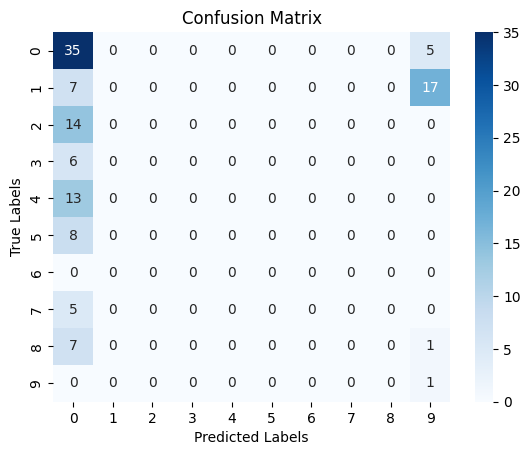

In [517]:
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model.pkl', model)
evaluate(model, train_iter)

Some weights of RobertaModel were not initialized from the model checkpoint at \\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000         8
           1     0.0000    0.0000    0.0000         6
           2     0.0000    0.0000    0.0000         1
           3     0.0000    0.0000    0.0000         0
           4     0.0000    0.0000    0.0000         1
           5     0.0000    0.0000    0.0000         4
           6     0.0000    0.0000    0.0000         1
           7     0.0000    0.0000    0.0000         2
           8     0.0000    0.0000    0.0000         7
           9     1.0000    0.2500    0.4000         4

   micro avg     1.0000    0.0294    0.0571        34
   macro avg     0.1000    0.0250    0.0400        34
weighted avg     0.1176    0.0294    0.0471        34
 samples avg     0.0556    0.0278    0.0370        34



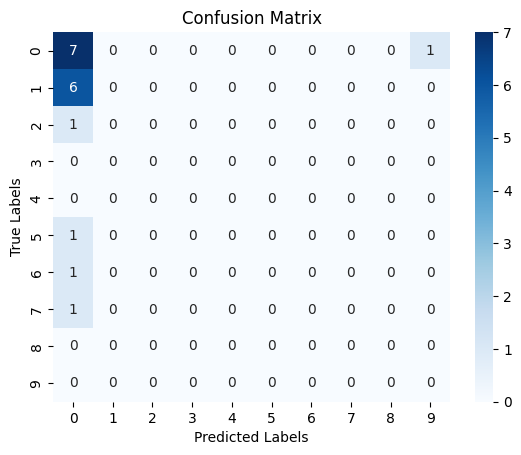

In [518]:
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model.pkl', model)
evaluate(model, test_iter)

In [523]:
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# Define category names
category_names = ['Access', 'Appearance of Site', 'Benefit Package', 'CMS issue',
 'Enrollment / Disenrollment', 'Humana Customer Service', 'Marketing',
 'Other', 'Provider Customer Service', 'Quality of Care']

# Function to decode the input sentences from their encoded form
def decode_sentences(encoded_sentences, tokenizer):
    decoded_sentences = [tokenizer.decode(sentence, skip_special_tokens=True) for sentence in encoded_sentences]
    return decoded_sentences

# Function to map binary labels to category names
def binary_to_categories(binary_labels, category_names):
    categories = []
    for labels in binary_labels:
        categories.append([category_names[i] for i, label in enumerate(labels) if label == 1])
    return categories

# Evaluation Function for Multi-Label Classification
def evaluate(model, test_loader, tokenizer, output_excel):
    y_pred = []
    y_true = []
    input_sentences = []
    probabilities = []

    model.eval()
    with torch.no_grad():
        for batch in test_loader:
            source = batch.Sentence
            target = batch.binary_labels
            mask = (source != PAD_INDEX).type(torch.uint8)
            
            output = model(source, attention_mask=mask)
            
            # Store input sentences
            input_sentences.extend(source.tolist())
            
            # Calculate probabilities
            probs = torch.sigmoid(output)
            probabilities.extend(probs.tolist())
            
            y_pred.extend((probs >= 0.5).int().tolist())
            y_true.extend(target.tolist())
    
    # Decode the input sentences
    decoded_sentences = decode_sentences(input_sentences, tokenizer)
    
    # Convert binary labels to category names
    y_true_categories = binary_to_categories(y_true, category_names)
    y_pred_categories = binary_to_categories(y_pred, category_names)
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=category_names, digits=4))
    
    # Compute confusion matrix for each label
    for i in range(10):
        cm = confusion_matrix([yt[i] for yt in y_true], [yp[i] for yp in y_pred])
        ax = plt.subplot(2, 5, i+1)
        sns.heatmap(cm, annot=True, ax=ax, cmap='Blues', fmt="d")
        ax.set_title(f'Label {category_names[i]}')
        ax.set_xlabel('Predicted')
        ax.set_ylabel('True')

    plt.tight_layout()
    plt.show()

    # Create a DataFrame to store the results
    results_df = pd.DataFrame({
        'Input Sentence': decoded_sentences,
        'Actual Categories': y_true_categories,
        'Predicted Categories': y_pred_categories,
    })

    # Add probability columns for each category
    for i, category in enumerate(category_names):
        results_df[f'{category} Probability'] = [prob[i] for prob in probabilities]

    # Save the DataFrame to an Excel file
    results_df.to_excel(output_excel, index=False)
    print(f"Results saved to {output_excel}")


Some weights of RobertaModel were not initialized from the model checkpoint at \\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Classification Report:
                            precision    recall  f1-score   support

                    Access     0.3824    1.0000    0.5532        13
        Appearance of Site     0.2353    1.0000    0.3810         8
           Benefit Package     0.0882    1.0000    0.1622         3
                 CMS issue     0.0882    1.0000    0.1622         3
Enrollment / Disenrollment     0.1471    1.0000    0.2564         5
   Humana Customer Service     0.2059    1.0000    0.3415         7
                 Marketing     0.1176    1.0000    0.2105         4
                     Other     0.1765    1.0000    0.3000         6
 Provider Customer Service     0.2647    1.0000    0.4186         9
           Quality of Care     0.2941    1.0000    0.4545        10

                 micro avg     0.2000    1.0000    0.3333        68
                 macro avg     0.2000    1.0000    0.3240        68
              weighted avg     0.2413    1.0000    0.3800        68
               samples 

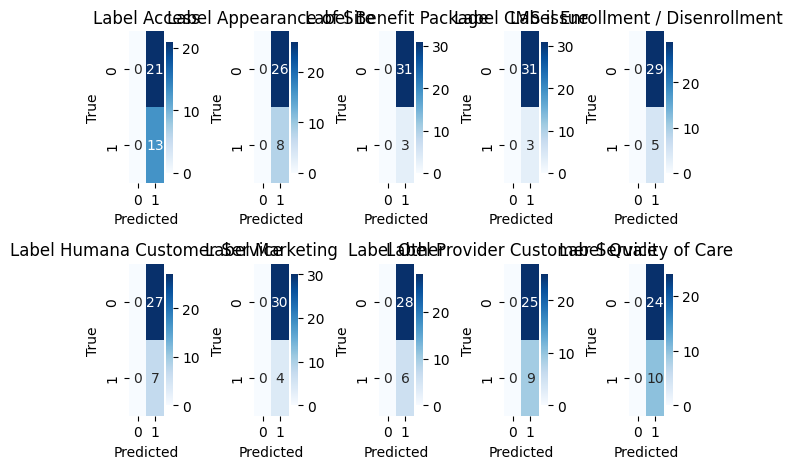

Results saved to evaluation_results.xlsx


In [525]:
# Example usage
model = ROBERTAClassifier()
model = model.to(device)
load_checkpoint(output_path + '/model.pkl', model)
evaluate(model, valid_iter, tokenizer, 'evaluation_results.xlsx')


In [ ]:
####Prediction for unknown data

In [ ]:
### 1. Class Prediction for Sentences in Excel File

import pandas as pd
import torch
from transformers import RobertaTokenizer

# Load the trained model
model_path = r"C:\Users\KPA2877\Documents\model.pkl"
model = ROBERTAClassifier()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model_state_dict'])
model.eval()

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(r"\\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base")

# Load the Excel file
input_file = r"Clean_Sentence_Split.xlsx"
df = pd.read_excel(input_file)

# Preprocess the sentences
def process_sentence(sentence):
    
    doc = nlp(sentence)  # Process the sentence with SpaCy
    cleaned_tokens = []   # Initialize an empty list to store modified tokens
    for token in doc:
        # Check if the token is not a name, organization, or location
        if token.ent_type_ not in ['PERSON', 'ORG', 'GPE']:
            # If not, add the token text to the cleaned_tokens list
            cleaned_tokens.append(token.text)
    cleaned_sentence = ' '.join(cleaned_tokens)  # Join the cleaned tokens back into a string
    return cleaned_sentence
   
   
def preprocess_text(text):
# Convert text to lowercase and strip whitespace
    text = text.lower().strip()
    # Remove hyperlinks
    text = re.sub(r'<a\s+(?:[^>]*?\s+)?href=(["\'])(.*?)\1[^>]*>(.*?)</a>', r'\3', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z .,!?]', '', text)   
    text=text.strip()
    # Apply SpaCy processing to the text
    cleaned_text = process_sentence(text)
   
    return cleaned_text

df['Sentence'] = df['Sentence'].apply(preprocess_text)

# Tokenize and predict
def predict(sentence):
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, prediction = torch.max(outputs, dim=1)
    
    return "Expedite" if prediction.item() == 1 else "Non Expedite"

df['Prediction'] = df['Sentence'].apply(predict)
df.to_excel(r"path_to_save_predictions2.xlsx", index=False)

In [32]:
import pandas as pd
import torch
from transformers import RobertaTokenizer
import re
import spacy

# Load the SpaCy model for named entity recognition
#nlp = spacy.load("en_core_web_sm")

# Load the trained model
model_path = r"C:\Users\KPA2877\Documents\model.pkl"
model = ROBERTAClassifier()
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu'))['model_state_dict'])
model.eval()

# Load the tokenizer
tokenizer = RobertaTokenizer.from_pretrained(r"\\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base")

# Load the Excel file
input_file = r"Clean_Sentence_Val.xlsx"
df = pd.read_excel(input_file)

# Preprocess the sentences
def process_sentence(sentence):
    doc = nlp(sentence)  # Process the sentence with SpaCy
    cleaned_tokens = []   # Initialize an empty list to store modified tokens
    for token in doc:
        # Check if the token is not a name, organization, or location
        if token.ent_type_ not in ['PERSON', 'ORG', 'GPE']:
            # If not, add the token text to the cleaned_tokens list
            cleaned_tokens.append(token.text)
    cleaned_sentence = ' '.join(cleaned_tokens)  # Join the cleaned tokens back into a string
    return cleaned_sentence

def preprocess_text(text):
    # Convert text to lowercase and strip whitespace
    text = text.lower().strip()
    # Remove hyperlinks
    text = re.sub(r'<a\s+(?:[^>]*?\s+)?href=(["\'])(.*?)\1[^>]*>(.*?)</a>', r'\3', text)
    # Remove special characters
    text = re.sub(r'[^a-zA-Z .,!?]', '', text)   
    text = text.strip()
    # Apply SpaCy processing to the text
    cleaned_text = process_sentence(text)
   
    return cleaned_text

df['Sentence'] = df['Sentence'].apply(preprocess_text)

# Tokenize and predict
def predict(sentence):
    inputs = tokenizer.encode_plus(
        sentence,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_tensors='pt'
    )
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probs = torch.softmax(outputs, dim=-1).squeeze().tolist()
        _, prediction = torch.max(outputs, dim=1)
    
    return prediction.item(), probs

# Predict and store results in DataFrame
predictions = []
probabilities = []

for sentence in df['Sentence']:
    pred_class, probs = predict(sentence)
    predictions.append(pred_class)
    probabilities.append(probs)

df['Predicted Class'] = predictions

# Add probability columns for each class
for i in range(10):
    df[f'Class {i} Probability'] = [prob[i] for prob in probabilities]

# Save the DataFrame to an Excel file
output_file = r"path_to_save_predictions2_Val.xlsx"
df.to_excel(output_file, index=False)

print(f"Results saved to {output_file}")


Some weights of RobertaModel were not initialized from the model checkpoint at \\rsc.humad.com\rdrive\FinRec\FRSolutions\FRS Reporting\RXS Information\Financial Reporting\Forecast Research Dashboard\Data Science\Member_grievance\Abhirup\Model\roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Results saved to path_to_save_predictions2_Val.xlsx


# Inference

In [ ]:
# Model with extra layers on top of RoBERTa
class ROBERTAClassifier(torch.nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ROBERTAClassifier, self).__init__()
        
        self.roberta = RobertaModel.from_pretrained('roberta-base')
        self.d1 = torch.nn.Dropout(dropout_rate)
        self.l1 = torch.nn.Linear(768, 64)
        self.bn1 = torch.nn.LayerNorm(64)
        self.d2 = torch.nn.Dropout(dropout_rate)
        self.l2 = torch.nn.Linear(64, 5)
        
    def forward(self, input_ids, attention_mask):
        _, x = self.roberta(input_ids=input_ids, attention_mask=attention_mask,return_dict=False)
        x = self.d1(x)
        x = self.l1(x)
        x = self.bn1(x)
        x = torch.nn.Tanh()(x)
        x = self.d2(x)
        x = self.l2(x)
        
        return x  

In [ ]:
t1=time.time()
def load_checkpoint(path, model):    
    state_dict = torch.load(path, map_location=device)
    model.load_state_dict(state_dict['model_state_dict'])   
    return model,state_dict['valid_loss']

model = ROBERTAClassifier()
model = model.to(device)
saved_model_path = output_path + '/model.pkl'  # Adjust this according to your setup
loaded_model, _ = load_checkpoint(saved_model_path,model)

# Load pre-trained model tokenizer
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
t2=time.time()
t2-t1

In [ ]:
txt=pd.read_excel(r"C:\RSS\jyothi\classification\train_data_03_04_24.xlsx")
sentences=list(txt['sentences'])

In [ ]:
sentences

In [ ]:
# Define a function to predict sentences in batches
def predict_sentences_batch(model, tokenizer, sentences, batch_size=32):
    predicted_labels = []
    dataloader = DataLoader(sentences, batch_size=batch_size)

    for batch in dataloader:
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=128)
        with torch.no_grad():
            outputs = model(**inputs)
        predicted_labels.extend(torch.argmax(outputs, dim=-1).tolist())
    return predicted_labels

t1 = time.time()
predicted_labels = predict_sentences_batch(loaded_model, tokenizer, sentences)
t2 = time.time()
print("Time taken:", t2 - t1)

In [ ]:
#avg time / sentence
(t2-t1)/950

In [ ]:
len(predicted_labels)